# Rule-Based Flagging

Court rulings can have different levels of impact. Some just follow routine procedures. Others raise important questions, like whether someone’s rights were violated, whether key evidence should have been allowed, or whether a judge made a surprising decision.

In this notebook we use simple, transparent rules to flag decisions that may contain procedural errors, unfair limitations on parties, or other mistakes that warrant further review. To achieve this, we will develop a labeling system based on the presence of specific legal phrases and procedural terms within the text of the rulings.

## Why Rule Based Flagging?

**Transparent for Legal Review**: Each flag can be traced back to the exact rule and phrase that triggered it, providing a clear and auditable trail for legal analysts.

**Reliable for known Legal patterns**: Especially effective in legal domains where specific phrases strongly indicate meaning (e.g., “terminated parental rights” → high risk).

## Project Objective & Plan

The goal of this notebook is to process a dataset of court decision texts and assign each document a **priority flag** ('High', 'Medium', 'Low') based on a set of predefined rules.

Our process will be as follows:

1. **Load & Explore Data**: We will load two key datasets: the main DataFrame of court rulings, previously cleaned in our `02_load_and_clean_rulings.ipynb` notebook, and our initial rule set from `labels.csv`. We will then perform a brief exploration of both to ensure they are loaded correctly.

2. **Apply Initial Model & Refine Rules**: Perform a first run of the Triage model, analyze the results, and then update the rule set based on a manual review.
3. **Apply Final Model & Analyze Results**: Re-run the Triage model with the improved rules and compare the "before and after" results to demonstrate the impact of the refinement.
4. **Generate Final Deliverable**: Save the final, annotated dataset as the key output of this project phase.


In [1]:
import os
os.chdir("/Users/lidasmac/compliance-nlp/")

In [27]:
# --- Standard Library Imports ---
import os
import re
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# --- Custom Module Imports ---
from src.rule_based_labeling import (
    find_matched_phrases,
    find_highest_risk_label
)

# --- Pandas Display Options ---
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)

# --- Autoreload  ---
# Automatically reload your custom functions when you change them.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Data Loading & Initial Exploration

In this step, we will load our two primary data sources:

1. **Court Rulings (`party_and_decision_metadata.csv`)**: This is our main dataset. Each row represents a specific court case and includes metadata and the text of the court's decision.
2. **Rule Labels (`labels.csv`)**: This file contains the phrases that form our rule-based system. Each row defines a specific rule, and its corresponding risk label.

In [3]:
# --- Load Data ---
try:
    df = pd.read_csv("data/party_and_decision_metadata.csv")
    labels_df = pd.read_csv("data/labels.csv")
    print("Data loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("\nPlease ensure you are running this notebook from the project root directory 'compliance-nlp/'")

Data loaded successfully!


### 1.1 Inspect the Main Dataset

Let's start by examining the main `df` DataFrame to understand its structure, data types, and check for any missing values.

In [4]:
# Get a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   doc_index      59 non-null     int64 
 1   party_line     59 non-null     object
 2   decision_text  59 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.5+ KB


In [5]:
# Display the first few rows to see the data's format
df.head()

,doc_index,party_line,decision_text
0,0,"The People of the State of New York, respondent, v Nicholas Palm, appellant.","Appeal by the defendant from a judgment of the County Court, Orange County (Craig S. Brown, J.), rendered May 16, 2023, convicting him of criminal..."
1,1,"Maria Airene Pantanilla, respondent, v Guillerma Yuson, appellant.","In an action, in effect, to recover damages for money had and received and unjust enrichment, the defendant appeals from a judgment of the Supreme..."
2,2,"Franklin Carroll, LLC, appellant, v Carroll Development Plaza, LLC, respondent.","In an action, inter alia, for injunctive relief and to recover damages for trespass, the plaintiff appeals from an order of the Supreme Court, Kin..."
3,3,"Pamela De Phillips, etc., appellant, v Nicole Pascone Perez, respondent.","In related proceedings pursuant to Family Court Act article 8, the petitioner appeals from an order of the Family Court, Kings County (Sharon N. C..."
4,4,"Bank of America, N.A., respondent, v Dale Bente, appellant, et al., defendants.","In an action to foreclose a mortgage, the defendant Dale Bente appeals from (1) an order of the Supreme Court, Suffolk County (S. Betsy Heckman To..."


The `.info()` output suggests our dataset is complete. As a final data quality check, we'll run an explicit count of missing (`NaN`) values to definitively confirm this.

In [6]:
# Count null values in each column.
df.isnull().sum()

doc_index        0
party_line       0
decision_text    0
dtype: int64

### 1.2 Inspect the Rules Dataset (`labels_df`)

Now we'll perform the same quick inspection on our `labels_df` to understand how our rules—the phrases and their corresponding labels—are structured.

In [7]:
# Get a concise summary of the labels_df DataFrame
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   phrase  16 non-null     object
 1   label   16 non-null     object
dtypes: object(2)
memory usage: 388.0+ bytes


In [8]:
# Display the first few rows to see a sample of the rules
labels_df.head()

,phrase,label
0,parental rights terminated,high
1,default judgment,high
2,appeal dismissed,medium
3,order affirmed,medium
4,judgment reversed,low


### 1.3 Analyze the Distribution of Labels
We need to know how many rules we have for each risk level. This helps us understand if our rule set is balanced or skewed.

In [9]:
# Get the distribution of labels. Jupyter will auto-display the result.
labels_df['label'].value_counts()

high      6
medium    6
low       4
Name: label, dtype: int64

### 1.4 Review Example Phrases for Each Label
Finally, to do a qualitative sanity check, let's loop through each risk level and see some of the phrases associated with it. This helps confirm our rules make intuitive sense.

In [10]:
# Group by the label and show all phrases from each group
for label_name, group in labels_df.groupby('label'):
    print(f"Risk Level: '{label_name}'")
    for phrase in group['phrase'].head():
        print(f"  - {phrase}")
    print("-" * 35)

Risk Level: 'high'
  - parental rights terminated
  - default judgment
  - conviction affirmed
  - custody transferred
  - suppressed evidence
-----------------------------------
Risk Level: 'low'
  - judgment reversed
  - conviction reversed
  - motion to dismiss granted
  - no appeal lies
-----------------------------------
Risk Level: 'medium'
  - appeal dismissed
  - order affirmed
  - remanded for further proceedings
  - motion to dismiss denied
  - best interests of the child
-----------------------------------


## Step 2: Apply the Rule-Based Phrase Matching

Using the dictionary of labeled phrases, we scan each decision text and record any phrases that appear. This helps us understand why a ruling might be flagged and supports later stages like prioritization, evaluation, and LLM-assisted refinement.

### 2.1 Prepare Data for Matching
Before we can search for phrases, we need to prepare both our source text and our rules to ensure consistent matching. We will:
1.  Convert the `decision_text` in our main DataFrame to lowercase and handle any missing values.
2.  Create an efficient lookup dictionary from our `labels_df`, also converting the phrases and labels to lowercase.

In [11]:
# --- Normalize text columns ---
df["decision_text"] = df["decision_text"].fillna("").str.lower()

# --- Create the rules lookup dictionary ---
label_dict = dict(zip(labels_df["phrase"].str.lower(), labels_df["label"].str.lower()))

### 2.2 Apply Phrase Matching Engine

Now that our data is prepared, we will apply our custom `find_matched_phrases` function to every document. This will create a new `flag_phrases` column containing a list of all rule phrases found in each text.

In [12]:
# Apply the function to create the 'flag_phrases' column
df["flag_phrases"] = df["decision_text"].apply(lambda text: find_matched_phrases(text, label_dict))

In [13]:
# Display the source text and the new 'flag_phrases' column together.
df[['decision_text', 'flag_phrases']].head()

,decision_text,flag_phrases
0,"appeal by the defendant from a judgment of the county court, orange county (craig s. brown, j.), rendered may 16, 2023, convicting him of criminal...",[ineffective assistance of counsel]
1,"in an action, in effect, to recover damages for money had and received and unjust enrichment, the defendant appeals from a judgment of the supreme...",[default judgment]
2,"in an action, inter alia, for injunctive relief and to recover damages for trespass, the plaintiff appeals from an order of the supreme court, kin...",[]
3,"in related proceedings pursuant to family court act article 8, the petitioner appeals from an order of the family court, kings county (sharon n. c...",[]
4,"in an action to foreclose a mortgage, the defendant dale bente appeals from (1) an order of the supreme court, suffolk county (s. betsy heckman to...",[]


## Step 3: Assign a Risk label from Flagged Phrases

Our goal is to assign a single, definitive risk label to each document. We will use a "Triage" approach: a document's final risk label will be determined by the most severe rule that it triggers. This allows us to quickly categorize all documents into clear buckets for review without requiring extensive tuning.

We will create a function that inspects the list of matched phrases and returns the single highest-ranking label found.

In [14]:
# Apply the custom labeling function to the 'flag_phrases' column.
df['risk_label_v1'] = df['flag_phrases'].apply(lambda phrase_list: find_highest_risk_label(phrase_list, label_dict))

In [15]:
# Display the source text, the 'flag_phrases', and the 'risk_label_v1' columns together.
df[['decision_text', 'flag_phrases', 'risk_label_v1']].head()

,decision_text,flag_phrases,risk_label_v1
0,"appeal by the defendant from a judgment of the county court, orange county (craig s. brown, j.), rendered may 16, 2023, convicting him of criminal...",[ineffective assistance of counsel],high
1,"in an action, in effect, to recover damages for money had and received and unjust enrichment, the defendant appeals from a judgment of the supreme...",[default judgment],high
2,"in an action, inter alia, for injunctive relief and to recover damages for trespass, the plaintiff appeals from an order of the supreme court, kin...",[],low
3,"in related proceedings pursuant to family court act article 8, the petitioner appeals from an order of the family court, kings county (sharon n. c...",[],low
4,"in an action to foreclose a mortgage, the defendant dale bente appeals from (1) an order of the supreme court, suffolk county (s. betsy heckman to...",[],low


### 3.1 Initial Model Run & Analysis
First, we'll run our Triage model using our current `labels.csv` file. The goal of this run is to produce a baseline result that we can analyze for potential improvements.

In [16]:
# This is the primary result of our triage model.
risk_buckets_v1 = df['risk_label_v1'].value_counts()
risk_buckets_v1

low       51
high       7
medium     1
Name: risk_label_v1, dtype: int64

### 3.2 Inspect High-Risk Documents

As a final sanity check, let's filter for the documents that were labeled 'high' and inspect the phrases that were flagged within them. This confirms that our most important rules are working as expected.

In [17]:
# --- 1. Filter the DataFrame to create a subset of only 'high' risk cases ---
high_risk_cases = df[df['risk_label_v1'] == 'high']

# --- 2. Display a sample of this subset, showing the most relevant columns ---
high_risk_cases[['decision_text', 'flag_phrases', 'risk_label_v1']].head()

,decision_text,flag_phrases,risk_label_v1
0,"appeal by the defendant from a judgment of the county court, orange county (craig s. brown, j.), rendered may 16, 2023, convicting him of criminal...",[ineffective assistance of counsel],high
1,"in an action, in effect, to recover damages for money had and received and unjust enrichment, the defendant appeals from a judgment of the supreme...",[default judgment],high
16,"appeals by the defendant from two judgments of the county court, suffolk county (mark d. cohen, j.), both rendered june 18, 2018, convicting him o...",[ineffective assistance of counsel],high
39,"in an action, inter alia, to recover damages for negligence, the plaintiff appeals from an order of the supreme court, orange county (david s. zuc...",[default judgment],high
41,"in an action, inter alia, to recover damages for false imprisonment and medical malpractice, the defendants appeal from an order of the supreme co...",[default judgment],high


### 3.3 Refinement: Analyzing Results and Improving the Rules

we now manually review the documents flagged by our initial model, so that we can validate our existing rules and discover new, high-impact phrases to make the system more intelligent.

#### Key Findings from Our Review
Our analysis of the initial high risk results was successful and yielded three key insights:

- **Validation of Existing Rules**: The review confirms that our core high risk rules are performing very well. Phrases like `effective assistance of counsel` and `default judgment` consistently identified documents with significant procedural and fairness issues, validating our initial strategy.

- **Confirmation of Proposed Phrases**: The review confirmed that several phrases we considered adding are indeed high-value. We saw `immigration consequences`, `failure to state a cause of action`, and `special duty` appear in the flagged documents, proving they are worth adding to our rule set.

- **Discovery of New High-Impact Phrases**: Most importantly, the review uncovered several new phrases that are strong indicators of a noteworthy case but were not yet in our system.

Based on the findings above, the clear next step is to update our `labels.csv` file. The table below lists the new rules we will add to create a more robust and nuanced model.

| New Phrase to Add (as a Pattern) | Suggested Label | Rationale |
| :--- | :--- | :--- |
| **`waived (his\|her\|their) right to appeal`** | `high` | Catches all gender variations of this key event in one rule. |
| **`violated (his\|her\|their) miranda rights`** | `high` | A fundamental constitutional challenge, now gender-neutral. |
| **`immigration consequences`** | `medium` | A critical factor in plea deals for non-citizens. |
| **`stop and frisk`** | `medium` | A key Fourth Amendment issue indicating a police procedure review. |
| **`unpreserved for appellate review`** | `medium` | An important procedural reason why a case's outcome was decided. |
| **`failure to state a cause of action`** | `medium` | A key reason for early-stage case dismissals. |

**ACTION: Manually Update `labels.csv`**

The next step is a manual one. I will now open the `data/labels.csv` file and add the new rules outlined in the table above, ensuring the regular expression patterns are correct. After saving the updated file, we will proceed with the cells below.

## Step 4: Final Model Run with Refined Rules

Now that our `labels.csv` file has been improved, we will re-run the entire analysis pipeline: first finding the matches with our new, larger rule set, and then applying the Triage logic.

### 4.1 Re-load Rules & Re-run Phrase Matching

First, we load the refined rule set and then re-run the phrase matching engine to create an updated list of flags for each document.

In [18]:
# Re-load the REFINED rules 
labels_df_final = pd.read_csv("data/labels_updated.csv")
label_dict_final = dict(zip(labels_df_final["phrase"].str.lower(), labels_df_final["label"].str.lower()))
print(f"Success! The refined rule set now contains {len(label_dict_final)} rules.")

Success! The refined rule set now contains 22 rules.


### 4.2 Apply Final Triage Model

With the updated flags, we now apply our Triage function to assign the final risk label.

In [19]:
# Re-run the phrase matching with the NEW rules 
# This creates a new 'final_flag_phrases' column containing our refined results.
df['final_flag_phrases'] = df['decision_text'].apply(
    lambda text: find_matched_phrases(text, label_dict_final)
)

In [20]:
# Display a sample to verify the flag phrase update 
# We'll display the NEW 'final_flag_phrases' column side-by-side
# with the original text to confirm the new rules worked.
df[['decision_text', 'final_flag_phrases']].head()

,decision_text,final_flag_phrases
0,"appeal by the defendant from a judgment of the county court, orange county (craig s. brown, j.), rendered may 16, 2023, convicting him of criminal...","[ineffective assistance of counsel, violated (his|her|their) miranda rights, stop and frisk, unpreserved for appellate review]"
1,"in an action, in effect, to recover damages for money had and received and unjust enrichment, the defendant appeals from a judgment of the supreme...",[default judgment]
2,"in an action, inter alia, for injunctive relief and to recover damages for trespass, the plaintiff appeals from an order of the supreme court, kin...",[]
3,"in related proceedings pursuant to family court act article 8, the petitioner appeals from an order of the family court, kings county (sharon n. c...",[]
4,"in an action to foreclose a mortgage, the defendant dale bente appeals from (1) an order of the supreme court, suffolk county (s. betsy heckman to...",[]


In [21]:
# Execute the FINAL Triage Analysis with the new rules 
# We apply our imported `find_highest_risk_label` function,
# passing it the new `label_dict_final`.
df['final_risk_label'] = df['final_flag_phrases'].apply(
    lambda phrase_list: find_highest_risk_label(phrase_list, label_dict_final)
)

# Display a sample to verify the new final column exists
df[['final_flag_phrases', 'risk_label_v1', 'final_risk_label']].head()

,final_flag_phrases,risk_label_v1,final_risk_label
0,"[ineffective assistance of counsel, violated (his|her|their) miranda rights, stop and frisk, unpreserved for appellate review]",high,high
1,[default judgment],high,high
2,[],low,low
3,[],low,low
4,[],low,low


### 4.3 Compare Before-and-After Results

By comparing the distribution of our initial run (`risk_label_v1`) with our final run (`final_risk_label`), we can see the direct impact of our work. We expect to see more documents categorized, especially in the `medium` and `high` buckets.

In [22]:
print("--- Initial Run Results (Before Refinement) ---")
display(df['risk_label_v1'].value_counts())

print("\n--- Final Run Results (After Refinement) ---")
display(df['final_risk_label'].value_counts())

--- Initial Run Results (Before Refinement) ---


low       51
high       7
medium     1
Name: risk_label_v1, dtype: int64


--- Final Run Results (After Refinement) ---


low       40
medium    11
high       8
Name: final_risk_label, dtype: int64

### 4.4 Interpretation of Final Results

The side-by-side comparison clearly demonstrates the success of our refinement cycle.

* **Successful Re-categorization:** The number of documents in the `low` risk category decreased by 11. These documents were successfully "upgraded" to more relevant risk categories.
* **High-Impact New Rules:** The `medium` risk category saw the most significant growth (from 1 to 11 cases), proving that our newly added `medium`-risk phrases were highly effective at identifying noteworthy cases that were previously missed. The `high` risk category also correctly identified one new case.

**Conclusion:** The manual process was highly effective. It improved the model's ability to correctly categorize documents, providing a more accurate set of labels for our final deliverable.

## Step 5: Create Final Deliverable

The comparison shows our refinements have successfully improved the model's coverage and classification. We are now ready to export our final, enriched dataset. This file is the key asset from this phase of the project and will be used for downstream analysis and review.

In [23]:
# Select the most useful columns for the final output.
# Including both v1 and final labels is great for documenting the changes.
final_deliverable_df = df[[
    'doc_index', # Or whatever your unique identifier column is
    'decision_text',
    'risk_label_v1',      # The "before" label
    'final_flag_phrases', # The full list of flags from the refined run
    'final_risk_label'    # The "after" label
]].copy()

# Save the annotated dataset to a new file in the 'data' directory
output_path = "data/decisions_with_risk_labels.csv"
final_deliverable_df.to_csv(output_path, index=False)

print("\nDisplaying a sample of the final deliverable:")
display(final_deliverable_df.head())


Displaying a sample of the final deliverable:


,doc_index,decision_text,risk_label_v1,final_flag_phrases,final_risk_label
0,0,"appeal by the defendant from a judgment of the county court, orange county (craig s. brown, j.), rendered may 16, 2023, convicting him of criminal...",high,"[ineffective assistance of counsel, violated (his|her|their) miranda rights, stop and frisk, unpreserved for appellate review]",high
1,1,"in an action, in effect, to recover damages for money had and received and unjust enrichment, the defendant appeals from a judgment of the supreme...",high,[default judgment],high
2,2,"in an action, inter alia, for injunctive relief and to recover damages for trespass, the plaintiff appeals from an order of the supreme court, kin...",low,[],low
3,3,"in related proceedings pursuant to family court act article 8, the petitioner appeals from an order of the family court, kings county (sharon n. c...",low,[],low
4,4,"in an action to foreclose a mortgage, the defendant dale bente appeals from (1) an order of the supreme court, suffolk county (s. betsy heckman to...",low,[],low


## Step 6: Model Performance Evaluation

With our `final_risk_label` generated by the model and our `human_label` prepared as a ground truth "answer key," we can now perform a final, quantitative evaluation. This will allow us to objectively measure how well our Triage model performed against our holistic, context-aware analysis.

### 6.1 Load and Merge Datasets

First, we'll load both our model's final output and our ground truth file, then merge them together on their common ID.

In [24]:
# Load the model's predictions
# We'll use the final deliverable file we created in the last step.
model_results_df = pd.read_csv("data/decisions_with_risk_labels.csv")

# Load our human-labeled "answer key"
ground_truth_df = pd.read_csv("data/ground_truth_labels.csv")

# Merge the two dataframes so each row has both the human label and the model's prediction
# We'll use the 'doc_index' column from your ground truth data as the key.
# First, let's ensure our main df has this column if it's just in the index.
if 'doc_index' not in model_results_df.columns:
    model_results_df.reset_index(inplace=True)
    model_results_df.rename(columns={'index': 'doc_index'}, inplace=True)


eval_df = pd.merge(model_results_df, ground_truth_df, on='doc_index')

eval_df[['doc_index', 'human_label', 'final_risk_label']].head()

,doc_index,human_label,final_risk_label
0,0,high,high
1,1,high,high
2,2,low,low
3,3,medium,low
4,4,medium,low


### 6.2 Confusion Matrix

A confusion matrix is the best way to visualize the performance of a classification model. It shows us exactly where the model was correct and where it was "confused."

* The **rows** will represent the **True Label** (from your human review).
* The **columns** will represent the **Model's Prediction**.
* The diagonal from top-left to bottom-right shows all the correct predictions.

--- Confusion Matrix ---


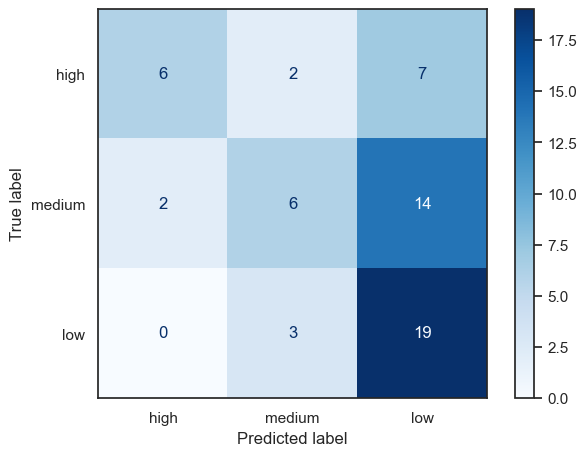

In [46]:
# Define the "true" answers and the model's "predicted" answers
y_true = eval_df['human_label']
y_pred = eval_df['final_risk_label']

# Define the order of your labels for the matrix axes so it's easy to read
labels = ['high', 'medium', 'low']

# Generate and display the matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

print("--- Confusion Matrix ---")
disp.plot(cmap=plt.cm.Blues)
plt.show()

### 6.3 Precision & Recall Report

From the confusion matrix, we can calculate the key performance metrics. The `classification_report` from scikit-learn does this for us automatically.

* **Precision:** "When the model predicted `high`, how often was it right?" (Measures reliability)
* **Recall:** "Of all the cases that were truly `high`, how many did the model find?" (Measures completeness)
* **F1-Score:** A weighted average of Precision and Recall, providing a single score for performance.

In [28]:
# Use the same variables and labels from the previous step
print("--- Classification Report ---")
print(classification_report(y_true, y_pred, labels=labels))

--- Classification Report ---
              precision    recall  f1-score   support

        high       0.75      0.40      0.52        15
      medium       0.55      0.27      0.36        22
         low       0.47      0.86      0.61        22
        none       0.00      0.00      0.00         0

   micro avg       0.53      0.53      0.53        59
   macro avg       0.44      0.38      0.37        59
weighted avg       0.57      0.53      0.50        59



/Users/lidasmac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lidasmac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lidasmac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lidasmac/anaconda3/l

## Step 7: Conclusion & Strategic Next Steps

This phase of the project successfully developed and deployed an end-to-end, rule-based Triage model capable of categorizing complex legal documents. The system effectively flags cases with high-risk procedural issues based on a transparent and explainable set of rules. The entire process, from initial analysis to manual refinement and quantitative evaluation, represents a complete "round 1" proof-of-concept.

### Final Performance Evaluation

The quantitative evaluation provides a clear performance baseline for the model in its current state.

* **Key Strength (Precision):** The model demonstrates high **precision (75%)** for the `high` risk category. This indicates that when the model flags a case as high priority, the flag is reliable and warrants attention.

* **Area for Improvement (Recall):** The primary area for future improvement is **recall (40% for `high`, 27% for `medium`)**. This shows that while the current rules are accurate, they are not yet comprehensive enough to find all relevant cases.

### Strategic Next Steps

The results of this evaluation define a clear and data-driven roadmap for "round 2" of this phase of the project, should it move forward in a real-world compliance context.

1.  **Targeted Rule Expansion to Improve Recall:**
    * The top priority would be to systematically analyze the "False Negatives" identified by the confusion matrix (e.g., cases that were labeled `low` by the model but `high` by the human expert).
    * This analysis would uncover the missing keywords and patterns needed to increase recall for the `high` and `medium` categories.

2.  **Introduce Granular Ranking:**
    * Once the recall is improved, the Triage model could be evolved into an "Accumulative Scoring" model.
    * This would provide a more granular numerical score, allowing for prioritization *within* the high-risk bucket (e.g., identifying the "highest of the high").

3.  **Productionization:**
    * The final logic would be packaged into a standalone Python script.
    * This script could be scheduled to run daily, processing new rulings and feeding a dashboard or alert system for legal analyst review.